# High-Dimensional Bayesian Optimization with SAASBO

This tutorial shows how to use the Sparse Axis-Aligned Subspace Bayesian Optimization (SAASBO) method for high-dimensional Bayesian optimization [1]. SAASBO places strong priors on the inverse lengthscales to avoid overfitting in high-dimensional spaces. Specifically, SAASBO uses a hierarchical sparsity prior consisting of a global shrinkage parameter $\tau \sim \mathcal{HC}(\beta)$ and inverse lengthscales $\rho_d \sim \mathcal{HC}(\tau)$ for $d=1, ..., D$, where $\mathcal{HC}$ is the half-Cauchy distribution. While half-Cauchy priors favor values near zero they also have heavy tails, which allows the inverse lengthscales of the most important parameters to escape zero. To do inference in the SAAS model we use Hamiltonian Monte Carlo (HMC) as we found that to outperform MAP inference.

We find that SAASBO performs well on problems with hundreds of dimensions. As we rely on HMC and in particular the No-U-Turn-Sampler (NUTS) for inference, the overhead of SAASBO scales cubically with the number of datapoints. Depending on the problem, using more than $100$ evaluations may not be feasible as SAASBO is designed for problems with a limited evaluation budget.

[1] D. Eriksson, M. Jankowiak. High-Dimensional Bayesian Optimization with Sparse Axis-Aligned Subspaces. Proceedings of the Thirty-Seventh Conference on Uncertainty in Artificial Intelligence, 2021.

In [1]:
import os

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch

from ax import Data, Experiment, ParameterType, RangeParameter, SearchSpace
from ax.core.metric import Metric
from ax.core.objective import Objective
from ax.core.optimization_config import OptimizationConfig
from ax.metrics.branin import BraninMetric
from ax.modelbridge.cross_validation import cross_validate
from ax.modelbridge.registry import Models
from ax.models.torch.botorch_modular.surrogate import Surrogate
from ax.runners.synthetic import SyntheticRunner
from botorch.models.fully_bayesian import SaasFullyBayesianSingleTaskGP

In [2]:
SMOKE_TEST = os.environ.get("SMOKE_TEST")

In [3]:
torch.manual_seed(12345)  # To always get the same Sobol points
tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}

## Setup search space and metric
In this simple experiment we use the Branin function embedded in a 30-dimensional space. Additional resources:
- To set up a custom metric for your problem, refer to the dedicated section of the Developer API tutorial: https://ax.dev/tutorials/gpei_hartmann_developer.html#8.-Defining-custom-metrics.
- To avoid needing to setup up custom metrics by Ax Service API: https://ax.dev/tutorials/gpei_hartmann_service.html.

In [4]:
search_space = SearchSpace(
    parameters=[
        RangeParameter(
            name=f"x{i}", parameter_type=ParameterType.FLOAT, lower=-5.0, upper=10.0
        )
        for i in range(25)
    ]
    + [
        RangeParameter(
            name=f"x{i + 25}",
            parameter_type=ParameterType.FLOAT,
            lower=0.0,
            upper=15.0,
        )
        for i in range(25)
    ]
)

optimization_config = OptimizationConfig(
    objective=Objective(
        metric=BraninMetric(
            name="objective",
            param_names=["x19", "x34"],
             # Set noise_sd=None if you want to learn the noise, set to 0.0 for no noise
            noise_sd=1e-4, 
        ),
        minimize=True,
    )
)

## Run benchmark

In [5]:
N_INIT = 10
BATCH_SIZE = 3
N_BATCHES = 1 if SMOKE_TEST else 10

print(f"Doing {N_INIT + N_BATCHES * BATCH_SIZE} evaluations")

Doing 40 evaluations


In [6]:
# Experiment
experiment = Experiment(
    name="saasbo_experiment",
    search_space=search_space,
    optimization_config=optimization_config,
    runner=SyntheticRunner(),
)

In [7]:
# Initial Sobol points
sobol = Models.SOBOL(search_space=experiment.search_space)
for _ in range(N_INIT):
    experiment.new_trial(sobol.gen(1)).run()

In [8]:
%%time
# Run SAASBO
data = experiment.fetch_data()
for i in range(N_BATCHES):
    model = Models.SAASBO(experiment=experiment, data=data)
    generator_run = model.gen(BATCH_SIZE)
    trial = experiment.new_batch_trial(generator_run=generator_run)
    trial.run()
    data = Data.from_multiple_data([data, trial.fetch_data()])

    new_value = trial.fetch_data().df["mean"].min()
    print(
        f"Iteration: {i}, Best in iteration {new_value:.3f}, Best so far: {data.df['mean'].min():.3f}"
    )

Iteration: 0, Best in iteration 10.961, Best so far: 3.963


Iteration: 1, Best in iteration 10.961, Best so far: 3.963


Iteration: 2, Best in iteration 1.947, Best so far: 1.947


Iteration: 3, Best in iteration 0.562, Best so far: 0.562


Iteration: 4, Best in iteration 13.889, Best so far: 0.562


Iteration: 5, Best in iteration 0.770, Best so far: 0.562


Iteration: 6, Best in iteration 0.535, Best so far: 0.535


Iteration: 7, Best in iteration 0.402, Best so far: 0.402


Iteration: 8, Best in iteration 0.410, Best so far: 0.402


Iteration: 9, Best in iteration 10.961, Best so far: 0.402
CPU times: user 1h 5min 27s, sys: 19min 39s, total: 1h 25min 6s
Wall time: 16min 3s


## Plot results
SAASBO is able to find a solution close to the global optimal value of 0.398

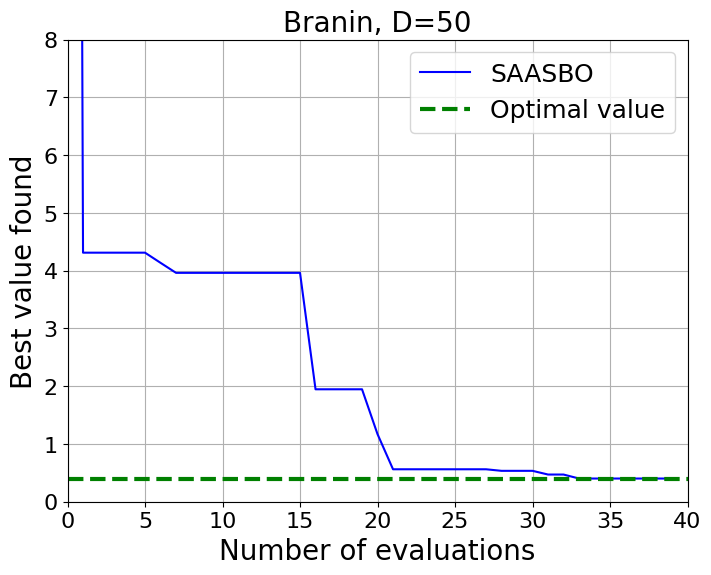

In [9]:
%matplotlib inline
matplotlib.rcParams.update({"font.size": 16})


fig, ax = plt.subplots(figsize=(8, 6))
res_saasbo = data.df["mean"]
ax.plot(np.minimum.accumulate(res_saasbo), color="b", label="SAASBO")
ax.plot([0, len(res_saasbo)], [0.398, 0.398], "--", c="g", lw=3, label="Optimal value")
ax.grid(True)
ax.set_title("Branin, D=50", fontsize=20)
ax.set_xlabel("Number of evaluations", fontsize=20)
ax.set_xlim([0, len(res_saasbo)])
ax.set_ylabel("Best value found", fontsize=20)
ax.set_ylim([0, 8])
ax.legend(fontsize=18)
plt.show()

## SAAS model fit

We can also instantiate a SAAS model via `Models.BOTORCH_MODULAR` by specifying a `SaasFullyBayesianSingleTaskGP` as the `botorch_model_class`. This also gives us the option to change several Pyro-specific parameters such as `num_samples` and `warmup_steps`.

In [10]:
model = Models.BOTORCH_MODULAR(
    experiment=experiment,
    data=data,
    surrogate=Surrogate(
        botorch_model_class=SaasFullyBayesianSingleTaskGP,
        mll_options={
            "num_samples": 256,  # Increasing this may result in better model fits
            "warmup_steps": 512,  # Increasing this may result in better model fits
        },
    )
)

### Cross-validation plot 
We have tools for cross-validation in Ax, but plotly doesn't render on Github so we make a simple plot using Matplotlib here. To use the built-in cross-validation functionality, you can do something like this:

```
from ax.modelbridge.cross_validation import cross_validate, compute_diagnostics
from ax.plot.diagnostic import interact_cross_validation
from ax.utils.notebook.plotting import render, init_notebook_plotting


cv = cross_validate(model)
diagnostics = compute_diagnostics(cv)
init_notebook_plotting()
plotconfig = interact_cross_validation(cv)
render(plotconfig)
```

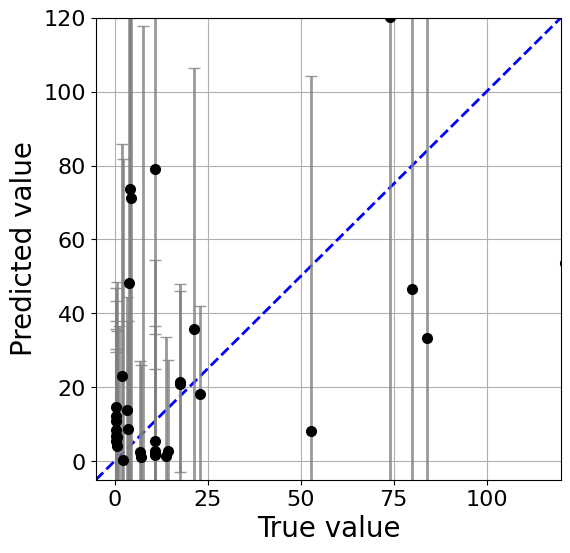

In [11]:
# Cross-validate model
cv = cross_validate(model)
y_true = np.stack([cv_.observed.data.means for cv_ in cv]).ravel()
y_saas_mean = np.stack([cv_.predicted.means for cv_ in cv]).ravel()
y_saas_std = np.stack(
    [np.sqrt(np.diag(cv_.predicted.covariance)) for cv_ in cv]
).ravel()

# Cross-validation plot
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
min_val, max_val = -5, 120
ax.plot([min_val, max_val], [min_val, max_val], "b--", lw=2)
markers, caps, bars = ax.errorbar(
    y_true,
    y_saas_mean,
    yerr=1.96 * y_saas_std,
    fmt=".",
    capsize=4,
    elinewidth=2.0,
    ms=14,
    c="k",
    ecolor="gray",
)
[bar.set_alpha(0.8) for bar in bars]
[cap.set_alpha(0.8) for cap in caps]
ax.set_xlim([min_val, max_val])
ax.set_ylim([min_val, max_val])
ax.set_xlabel("True value", fontsize=20)
ax.set_ylabel("Predicted value", fontsize=20)
ax.grid(True)

### Lengthscales
As SAASBO places strong priors on the inverse lengthscales, we only expect parameters 19 and 44 to be identified as important by the model since the other parameters have no effect. We can confirm that this is the case below as the lengthscales of parameters 19 and 44 are close to 1 with all other lengthscales being larger than 1000.  

In [12]:
median_lengthscales = (
    model.model.surrogate.model
    .covar_module.base_kernel.lengthscale.squeeze()
    .median(axis=0)
    .values
)
for i in median_lengthscales.argsort()[:10]:
    print(f"Parameter {i:2}) Median lengthscale = {median_lengthscales[i]:.2e}")

Parameter 33) Median lengthscale = 1.20e-01
Parameter 41) Median lengthscale = 6.28e-01
Parameter  0) Median lengthscale = 7.96e-01
Parameter 19) Median lengthscale = 3.88e+01
Parameter 45) Median lengthscale = 3.90e+01
Parameter 21) Median lengthscale = 4.01e+01
Parameter 22) Median lengthscale = 4.25e+01
Parameter  1) Median lengthscale = 4.25e+01
Parameter 34) Median lengthscale = 4.29e+01
Parameter 42) Median lengthscale = 4.30e+01
